In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wtoken
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import tensorflow as tf
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Activation, Dropout, Dense, Embedding, Flatten, GlobalMaxPooling1D)
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, string, gc
from tqdm import tqdm
import tldextract as tld


from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%timeit
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  1


In [3]:
def test_tf_gpu():
    tf.debugging.set_log_device_placement(True)
    # Create some tensors
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print(c)

In [4]:
train = pd.read_csv('../kaggle/input/google-quest-challenge/train.csv')
test = pd.read_csv('../kaggle/input/google-quest-challenge/test.csv')
samsub = pd.read_csv('../kaggle/input/google-quest-challenge/sample_submission.csv')

In [5]:
train.isnull().values.any()

False

In [6]:
test.isnull().values.any()

False

# Processing domains/urls and convert it to categorical feature, e.g. topic, class, etc..

In [7]:
def ext_subdomains(column):
    """
    intent: extracts subdomains from urls by using tldextract lib
    accepts: a dataframe column/pandas series of urls.
    returns: a list of extracted subdomains.
    """
    subdomains = []
    for c in column:
        subdomains.append(tld.extract(c).subdomain)
    return subdomains

In [8]:
train['topic'] = ext_subdomains(train.url)

In [9]:
test['topic'] = ext_subdomains(test.url)

In [10]:
targets = list(samsub.columns)
targets.pop(0)

'qa_id'

In [11]:
Y = train[targets]

In [12]:
features = ['question_title', 'question_body', 'answer', 'topic', 'category' ]

In [13]:
features_txt = ['question_title', 'question_body', 'answer']

In [14]:
train = train[features]

In [15]:
test = test[features]

In [16]:
train.shape

(6079, 5)

In [17]:
test.shape

(476, 5)

In [18]:
X = train.append(test)

## Label Encoding

In [19]:
# Label Encoding
for c in tqdm( ['topic','category']):
    enc = LabelEncoder()
    enc.fit(X[c])
    X[c] = enc.transform(X[c])

100%|██████████| 2/2 [00:00<00:00, 452.53it/s]


In [20]:
# Convert all chars to lower

for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].str.lower()

100%|██████████| 3/3 [00:00<00:00, 123.32it/s]


## Tokenization with NLTK

In [21]:
from nltk.tokenize import word_tokenize

tokenized_answer=[]

for doc in tqdm(X.answer):
    tokenized_answer.append(word_tokenize(doc))


100%|██████████| 6555/6555 [00:05<00:00, 1167.82it/s]


In [22]:
tokenized_question_body=[]
for doc in tqdm(X.question_body):
    tokenized_question_body.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:05<00:00, 1222.35it/s]


In [23]:
tokenized_question_title=[]
for doc in tqdm(X.question_title):
    tokenized_question_title.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:00<00:00, 12181.50it/s]


In [24]:
def remove_non_english(text):
    result = []
    
    for words in tqdm(text):
        result.append([x.replace(re.sub(r'[aA-zZ]',r'',x), '') for x in words])
    return result

In [25]:
def remove_nonalpha(text):
    
    result = []
    
    for w in tqdm(text):
        
        result.append([x for x in w if x.isalpha() and x.isascii()])
    
    return result

In [26]:
def remove_char(text, c=''):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if x !=c])
    return result

In [27]:
def remove_long_words(pd_series):
    # expects a pandas dataframe column/seires 
    # removes any word by its length range( 4-12 chars)
    # returns a list of strings
    result = []
    result = tqdm(pd_series.str.findall('\w{4,12}').str.join(' '))
    return result

In [28]:
def remove_words(text, min_length = 4, max_length = 12):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if len(x) in range(min_length, max_length)])
    return result

In [29]:
tokenized_answer= remove_nonalpha(tokenized_answer)

X['answer'] = remove_char(tokenized_answer)

X['answer'] = remove_words(X['answer'])

100%|██████████| 6555/6555 [00:00<00:00, 30236.94it/s]


In [30]:
tokenized_question_body= remove_nonalpha(tokenized_question_body)

X['question_body'] = remove_char(tokenized_question_body)

X['question_body'] = remove_words(X['question_body'])

100%|██████████| 6555/6555 [00:00<00:00, 32204.51it/s]


In [31]:
tokenized_question_title= remove_nonalpha(tokenized_question_title)

X['question_title'] = remove_char(tokenized_question_title)

X['question_title'] = remove_words(X['question_title'])

100%|██████████| 6555/6555 [00:00<00:00, 339080.48it/s]


In [32]:
del tokenized_answer, tokenized_question_body, tokenized_question_title
gc.collect()

22

## Removing stopwords

In [33]:
stopwords = stopwords.words('english')
for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].apply(lambda x: [word for word in x if word not in stopwords])

100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


## Stemming

In [34]:
lemmatizer = WordNetLemmatizer() 

for f in tqdm(['question_title', 'question_body', 'answer']):
     X[f] = X[f].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


In [35]:
# Stemming using NLTK SnowballStemmer (aka Porter2)

stemming = nltk.stem.snowball.SnowballStemmer("english", ignore_stopwords=True)

for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].apply(lambda x: [stemming.stem(word) for word in x])

100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


## Frequency Distribution

In [36]:

def frequency_distr(text):
    
    freq_dist = {}
    
    allWords = []
    
    for wordList in text:
        allWords += wordList

    # Frequency dist.
    freq_dist = nltk.FreqDist(allWords)

    # Take only the words
    word_features_qt = list(freq_dist.keys())#[:5000]

    print('Number of words: {}'.format(len(freq_dist)))
    print('Most common words: {}'.format(freq_dist.most_common(10)))
    return freq_dist

In [37]:
fdist_qt = {}
fdist_qb = {}
fdist_an = {}

fdist_qt = frequency_distr(X['question_title'])

fdist_qb = frequency_distr(X['question_body'])

fdist_an = frequency_distr(X['answer'])

    

Number of words: 4504
Most common words: [('use', 311), ('file', 194), ('differ', 188), ('chang', 160), ('make', 152), ('work', 137), ('server', 127), ('window', 123), ('page', 123), ('find', 122)]
Number of words: 12761
Most common words: [('would', 2850), ('use', 2846), ('like', 2682), ('work', 2090), ('want', 1958), ('file', 1760), ('know', 1590), ('question', 1583), ('time', 1562), ('need', 1537)]
Number of words: 18016
Most common words: [('use', 2836), ('would', 2640), ('like', 2446), ('need', 2141), ('also', 1832), ('make', 1821), ('work', 1693), ('time', 1619), ('want', 1560), ('file', 1419)]


In [38]:
#fdist_qt= {k: v for k, v in sorted(fdist_qt.items(), key=lambda item: item[1])}

In [39]:
X['question_title'].values[500]

['read', 'file', 'network', 'locat']

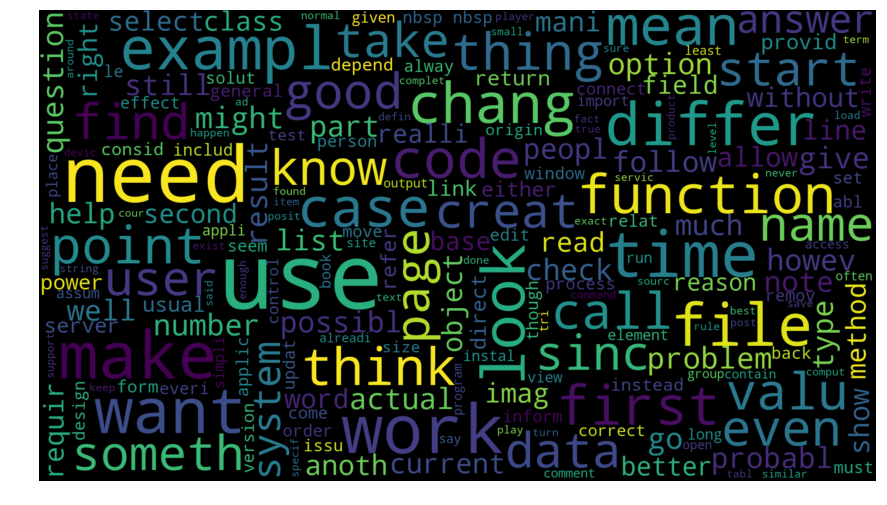

In [42]:
all_words=''
for w in X.answer:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

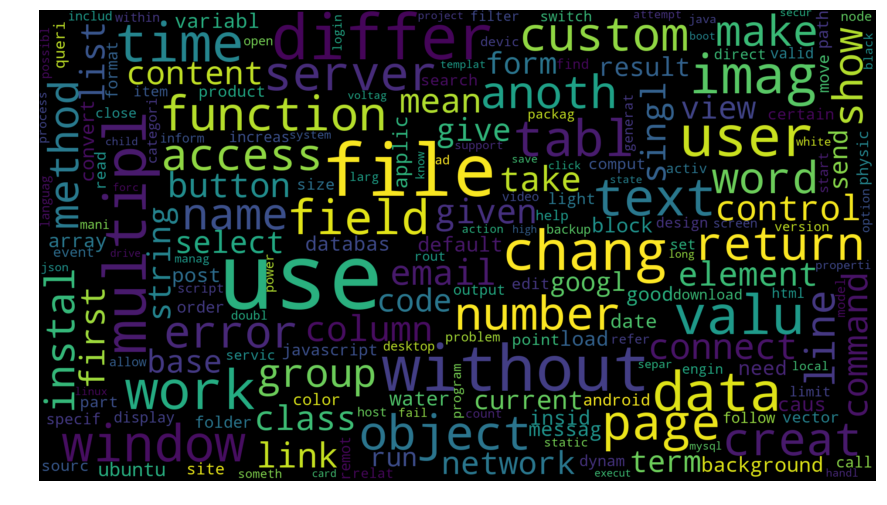

In [43]:
all_words=''
for w in X.question_title:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

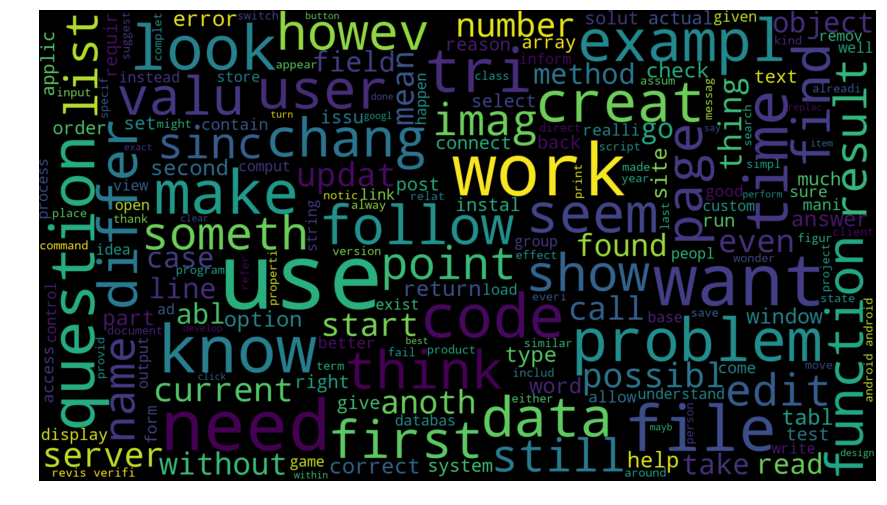

In [44]:
all_words=''
for w in X.question_body:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

In [45]:
X.head()

,question_title,question_body,answer,topic,category
0,"[lose, use, extens, tube, instead, macro, len]","[play, around, macro, photographi, read, rever...","[extens, tube, skinni, lose, use, tube, amount...",39,1
1,"[distinct, citi, downtown, commerci, district]","[tri, understand, kind, place, spam, valu, ref...","[might, help, look, definit, spam, zone, spam,...",44,0
2,"[maximum, protus, length, compon, pin]","[work, compon, side, board, side, board, mount...","[even, need, groov, make, sever, product, use,...",19,2
3,"[affidavit, use, beit]","[affidavit, understand, basic, sign, document,...","[send, affidavit, disput, rashi, rabbeinu, dev...",27,0
4,"[make, binari, imag, photoshop]","[tri, make, binari, imag, want, look, imag, wa...","[check, imag, trace, adob, illustr, like, use,...",26,1
